In [1]:
import pandas as pd
import math
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
from spacy.lang.es.stop_words import STOP_WORDS as es_stop
import nltk

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
stopwords_list = list(en_stop) + list(es_stop)

In [2]:
tweets1_1 = pd.read_csv("./data/hashtag_donaldtrump.csv", lineterminator="\n")
tweets1_2 = pd.read_csv("./data/hashtag_joebiden.csv", lineterminator="\n")
tweets2_1 = pd.read_csv("./data/2020-US-election-tweets.csv", sep=",")
tweets = pd.DataFrame()

In [3]:
def parser (tweet, likes, retweets, date):
    """ La funcion estandariza los tipos de datos con los que se va a trabajar ... 
        args:
            tweet (): object
            likes(): numeric
            retweets(): numeric
            date (): object
        return : DataFrame
    """
    df = pd.DataFrame({'tweet': tweet.astype(str), 
                       'likes':likes.astype('int64'), 
                       'retweets': retweets.astype('int64'), 
                       'date': pd.to_datetime(date, errors='coerce').dt.date})
    return df    

In [4]:
tweets = tweets.append(parser(tweets1_1['tweet'], tweets1_1['likes'], tweets1_1['retweet_count'], tweets1_1['created_at']))
tweets = tweets.append(parser(tweets1_2['tweet'], tweets1_2['likes'], tweets1_2['retweet_count'], tweets1_2['created_at']))
tweets = tweets.append(parser(tweets2_1['tweet'], tweets2_1['likes_count'], tweets2_1['retweets_count'], tweets2_1['date']))
tweets = tweets.sort_values('date', ascending=False)

In [5]:
def clean(tweet):
    """ La funcion elimina los caracteres especiales, links, saltos de linea, tabulaciones, signos de puntuacion ... 
        
        args:
            text (): Series
        return : Series
    """
    tweet = tweet.str.lower()
    tweet = tweet.apply(lambda x: ' '.join([item for item in x.split() if item not in stopwords_list]))
    tweet = tweet.str.strip()
    tweet = tweet.replace('(\w+:\/\/\S+|http\S+)', '', regex=True)
    tweet = tweet.replace('(@|#)', '', regex=True)
    tweet = tweet.replace('[^a-z0-9\\s]', '', regex=True)
    tweet = tweet.apply(lambda x: ' '.join(x.split()))
    
    return tweet

In [6]:
tweets['tweet'] = clean(tweets.tweet)
tweets = tweets.dropna()
tweets.to_csv("./data/tweets.csv", sep=',', index=False)

In [7]:
def flatten(l):
    """ La funcion aplana una lista de listas 
        
        args:
            l (): lista de listas
        return : lista aplanada
    """
    return [item for sublist in l for item in sublist]

In [8]:
tweets_words = [tweet.split() for tweet in tweets['tweet'][:1000]]
tweets_words = flatten(tweets_words)
fdist1 = nltk.FreqDist(tweets_words)
print (fdist1.most_common(50))

[('joebiden', 1081), ('kamalaharris', 222), ('biden', 150), ('trump', 135), ('president', 122), ('bidenharris2020', 110), ('joe', 99), ('donaldtrump', 88), ('election2020', 84), ('joebidenkamalaharris2020', 83), ('election', 64), ('amp', 64), ('ripmoana', 63), ('realdonaldtrump', 61), ('america', 58), ('trumpout', 56), ('usa', 55), ('congratulations', 49), ('holyground', 46), ('jessicaiskandar', 46), ('presidentelect', 41), ('2020', 39), ('victory', 39), ('world', 39), ('time', 33), ('y', 33), ('going', 31), ('yourefired', 31), ('new', 30), ('uselectionresults2020', 30), ('whitehouse', 29), ('people', 29), ('win', 29), ('harris', 28), ('8', 28), ('presidentelectjoe', 27), ('like', 25), ('us', 25), ('usaelection2020', 25), ('fourseasonslandscaping', 25), ('elections2020', 24), ('presidente', 23), ('gisellaanastasia', 23), ('treasuremmminkigayo', 23), ('vg2020', 23), ('news', 22), ('united', 22), ('good', 22), ('it', 22), ('states', 21)]


In [9]:
def word_cloud(wd_list, qtty):
    """ La funcion grafica la cantidad de ocurrencias con mayor repeticion ... 
        
        args:
            wd_list (): pd.Series
            qtty (): int
        return : none
    """
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=qtty,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");

def tweets_candidate(tweet, candidate) :
    count = 0
    for text in tweet.iteritems():
        if candidate in text: 
           count =+ 1
    return count

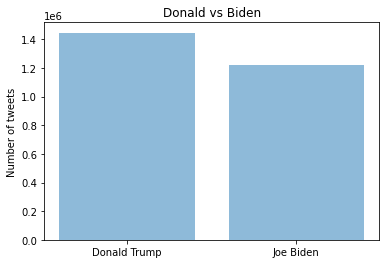

In [10]:
# Numero de tweets que menciona Donald Trump -- grafico de barras
trump_tweets = tweets[tweets.tweet.str.contains(pat='trump', case=False)]
biden_tweets = tweets[tweets.tweet.str.contains(pat='biden', case=False)]

objects = ('Donald Trump','Joe Biden')
y_pos = np.arange(len(objects))
performance = [trump_tweets.shape[0],biden_tweets.shape[0]]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of tweets')
plt.title('Donald vs Biden')

plt.show()

In [11]:
# Cantidad de menciones a traves del tiempo para cada candidato-- grafico de lineas
trump_tweets['date2'] = trump_tweets['date'].apply(lambda d: str(d.day)+"-"+str(d.month))
biden_tweets['date2'] = biden_tweets['date'].apply(lambda d: str(d.day)+"-"+str(d.month))
mencions_month_trump = trump_tweets.groupby(trump_tweets['date2']).apply(lambda x: pd.Series({
        'trump': x.tweet.count()
}))
mencions_month_biden = biden_tweets.groupby(biden_tweets['date2']).apply(lambda x: pd.Series({
        'biden': x.tweet.count()
}))

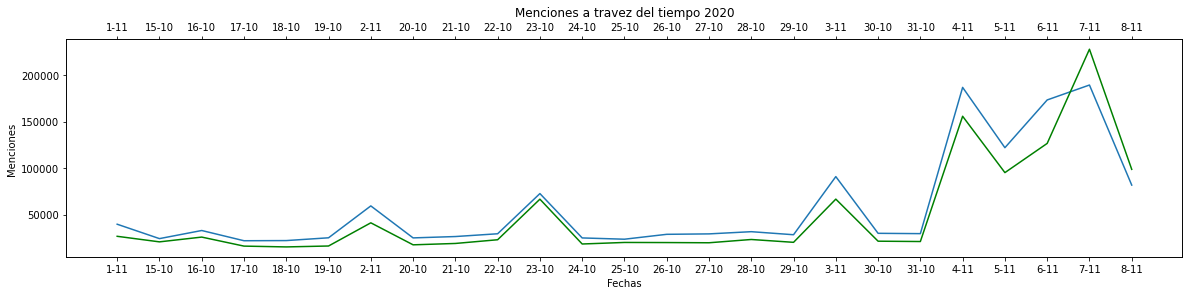

In [12]:
fig, ax1 = plt.subplots(figsize= (20,4))
 
ax1.plot(mencions_month_trump)
#Para poder realizar ambos plots en uno pero con diferentes escalas en el eje x, usamos twiny que nos permite compartir el eje y
ax2 = ax1.twiny()
ax2.plot(mencions_month_biden, color='g')
ax1.set_title("Menciones a travez del tiempo 2020")
ax1.set_xlabel("Fechas")
ax1.set_ylabel("Menciones")
plt.show()

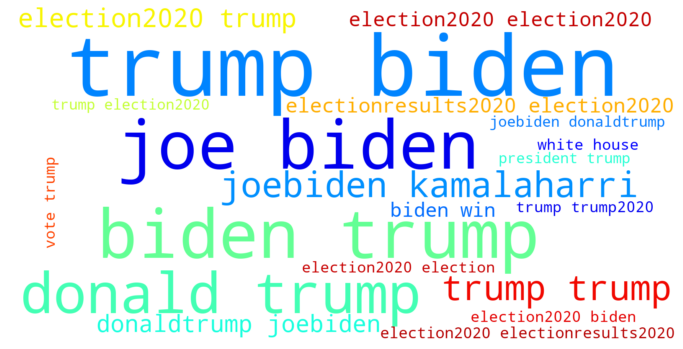

In [13]:
# Las 20 Palabras mas comunes
word_cloud(tweets['tweet'], 20)

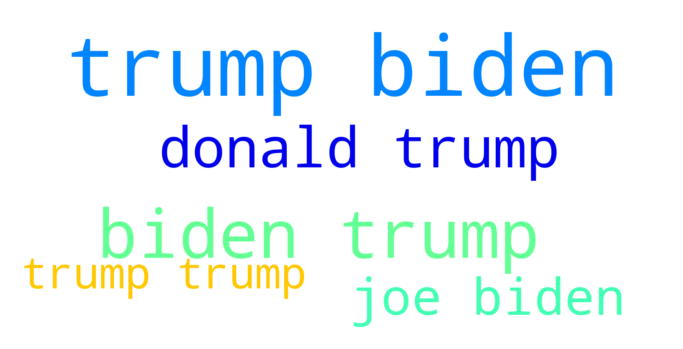

In [14]:
# 5 Palabras mas comunes para Donald Trump -- imshow
word_cloud(trump_tweets['tweet'], 5)

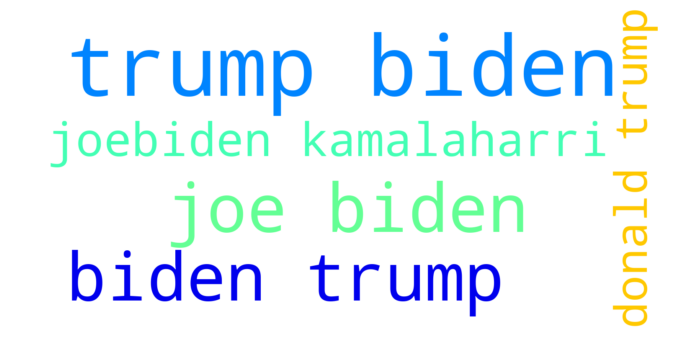

In [15]:
# 5 Palabras mas comunes para Joe Biden -- imshow
word_cloud(biden_tweets['tweet'], 5)